In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context='talk', font_scale=1., font="Helvetica")
sns.set_palette(sns.color_palette('bright'))
%matplotlib inline

In [2]:
%run pripop.py

# Using _PriPOP_ to simulate the dynamics of _Pristionchus pacificus_

## Single population

- In the first step, we specify the dimensions of the three lattices, and the type of bacterial resource available (OP50 or Novo)

In [3]:
dim = (20,20)
diet = 'OP50'
pop = Population(dim, resource_type=diet)

-  In the next step, we can add worms to the lattices. Each worm is specified as a tuple: (developmental stage, age, strain, mouth form, unique identifier).

In [4]:
pop.add_worm(('J', 0, 'P', 'NA', None))

- Then, we can simulate the dynamics of the population for a number of hours:

In [5]:
t = 200
pop.simulate(t, verbose=True)

100%|██████████| 200/200 [00:02<00:00, 75.82it/s]  


[Text(0, 0.5, 'Number of each stage'), Text(0.5, 0, 'Time (hours)')]

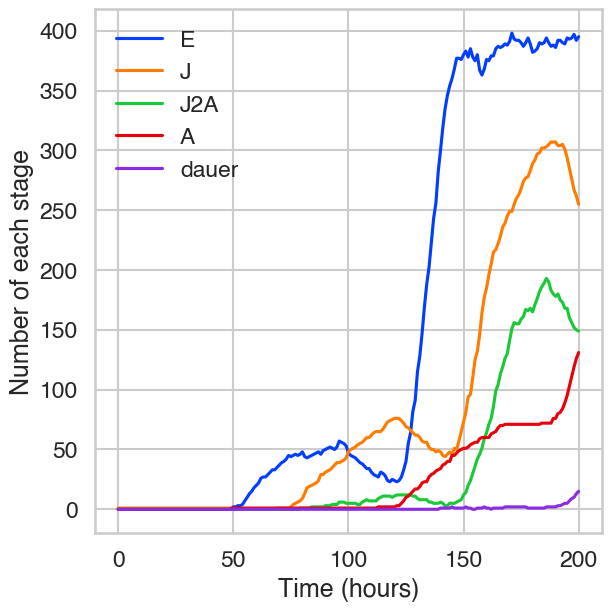

In [6]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 6),
    constrained_layout=True)

x = np.arange(0, t+1, 1)

for stage in ['E', 'J', 'J2A', 'A', 'dauer']:
    ax.errorbar(x, pop.history['P'][stage], label=stage)
        
ax.legend(loc='best', frameon=False)

ax.set(ylabel='Number of each stage', xlabel='Time (hours)')

## Metapopulation

In [7]:
# I) Specify the number of populaions in the metapopulation
n_pop = 2
# II) Specify the bacterial source in each population
diets = ["OP50", "Novo"]  
# III) Create neighboring pattern. If ring True, the first population is connected to the last population. 
neigs = create_neighbor_dict(n_pop, ring=True) 
# IV) Create populations 
metapop = {}
for i,j in zip(range(n_pop), diets):
    # mig_rate is set at 0.0 since migration is handled at the metpopulation level.
    metapop[i] = Population(dim, resource_type=j, mig_rate=0.0)
# V) Add worms of a strain of interest  to each population 
n0 = 10 
for j in range(n0):
    metapop[0].add_worm(('A', 0, "P", 'ND', None))
# VI) Simulate the dynamics over the metapopulation for a gicen duration and given migration rate (m_rate)
t_sim = 200
m_rate = 0.05
for i in range(n_pop):
    metapop[i].init_history()
    metapop[i].update_history()
for j in range(t_sim):
    for subpop in range(n_pop):
        metapop[subpop].take_a_step()
        metapop[subpop].update_history()
    possible_migrants = {k2: [k for i, (k,v)  in enumerate(v2.middle_layer.items()) if v[0] == 'dauer'] for i2, (k2, v2) in enumerate(metapop.items())}
    migrants = migration(possible_migrants, neigs, m_rate)
    if len(migrants) > 0:
        for loc, d, r in migrants:
            if len(metapop[r].empty_loc_top) > 0:
                metapop[r].add_dauer(metapop[d].middle_layer[loc])
                del metapop[d].middle_layer[loc]
# VII) Get the srtrain frequencies as a data frame 
output = pd.DataFrame()
for subpop in range(n_pop):
    for strain in ['P', 'NP', 'MP']:
        temp = pd.DataFrame.from_dict(metapop[subpop].history[strain])
        temp['strain'] = strain
        temp['subpop'] = subpop
        output = pd.concat([output, temp])
output = output.reset_index()

In [8]:
output.head()

,index,E,J,J2A,A,EU_prop,dauer,strain,subpop
0,0,0,0,0,10,0.0,0,P,0
1,1,14,0,0,10,0.0,0,P,0
2,2,24,0,0,10,0.0,0,P,0
3,3,28,0,0,10,0.0,0,P,0
4,4,45,0,0,10,0.0,0,P,0


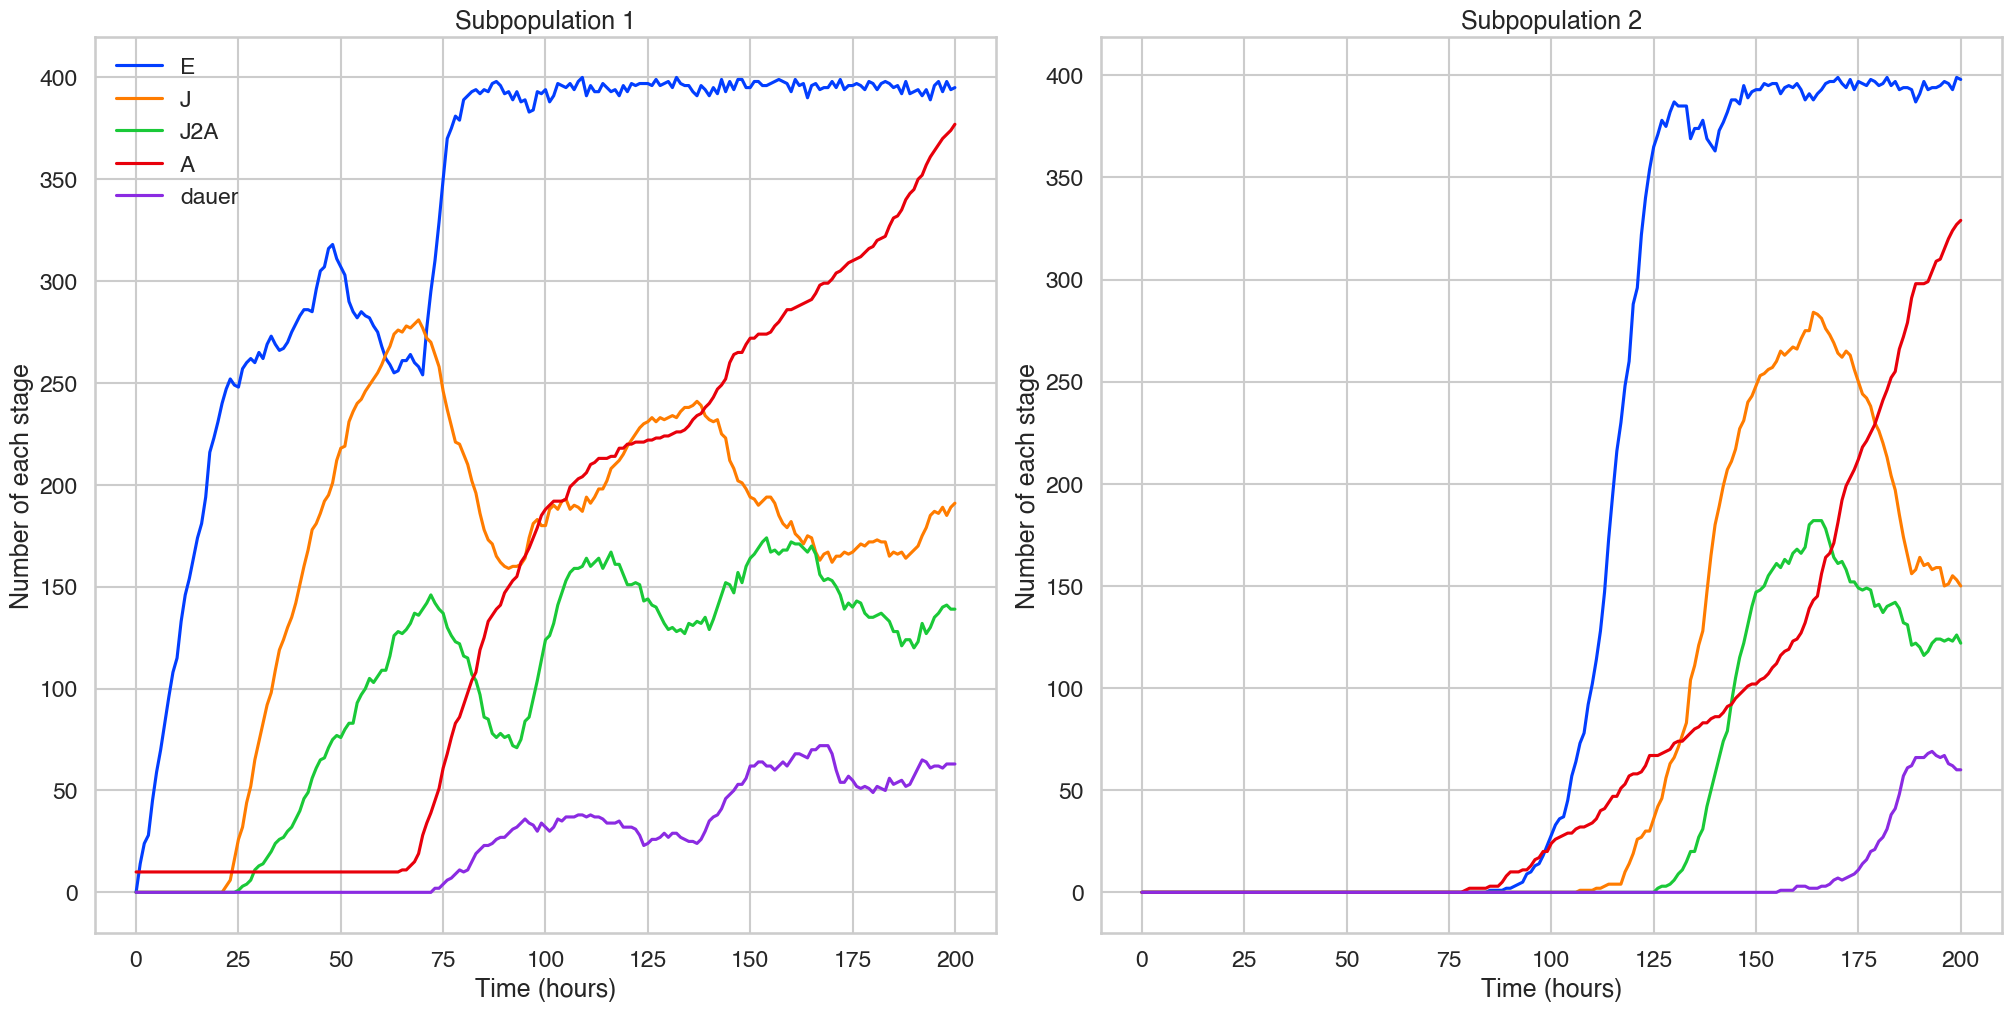

In [9]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=n_pop,
    figsize=(20, 10),
    constrained_layout=True)

axes = axes.flatten()

strain_dic = {'P' : 'A', 'MP': 'B', 'NP': 'C'}

stages = ['E', 'J', 'J2A', 'A', 'dauer']
x = np.arange(0, t_sim+1, 1)
for i in range(n_pop):
    temp = output[output['subpop']==i]
    count = 0
    for stage in stages:
        axes[i].plot(x, np.array(temp[temp['strain']=='P'][stage]), alpha=1, color=sns.color_palette('bright')[count], label=stage)
        count += 1
    axes[i].set(ylabel='Number of each stage', xlabel='Time (hours)', title='Subpopulation ' + str(i+1))

axes[0].legend(loc='best', frameon=False)